<a href="https://colab.research.google.com/github/DerManjuel/MDL/blob/main/MDL_Exercise6_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u>M</u>edical <u>D</u>eep <u>L</u>earning
## Exercise 6: Variational Auto-Encoder

The goal of this exercise is to implement an unsupervised method to adapt the data distribution of our well known Pneumonia Torso X-Ray dataset of the very first exercise.

![VAE](https://cloud.imi.uni-luebeck.de/s/fBDPZdQGajmcfeN/download)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

## Dataset implementation
Provided dataset implementation of 0th exercise.

In [3]:
!pip install wget
import wget
from os.path import exists
from torch.utils.data import Dataset


class PneumoniaXRayDataset(Dataset):
    def __init__(self, mode: str):
        super(PneumoniaXRayDataset, self).__init__()
        # load data
        data_file = 'pneumonia_detection_data_img.pth'
        label_file = 'pneumonia_detection_data_label.pth'

        if not exists(data_file):
            data_file = wget.download(
                'https://cloud.imi.uni-luebeck.de/s/7Re8XdKCxpTZDk2/download/pneumonia_detection_data_img.pth')
        if not exists(label_file):
            label_file = wget.download(
                'https://cloud.imi.uni-luebeck.de/s/XgccQesxFeT9EqE/download/pneumonia_detection_data_label.pth')

        img = torch.load(data_file)
        lbl = torch.load(label_file)

        img = (img - img.min()) / (img.max() - img.min())
        img = img * 2 - 1

        torch.manual_seed(42)
        rand_idx = torch.randperm(len(lbl))

        # split data
        if mode == 'train':
            self.idx = rand_idx[:4500]
        elif mode == 'val':
            self.idx = rand_idx[4500:5000]
        elif mode == 'test':
            self.idx = rand_idx[5000:]
        else:
            raise ValueError(f'unknown mode: {mode}. Valid modes are train, val and test')

        self.img = img[self.idx]
        self.lbl = lbl[self.idx]

    def __len__(self):
        return len(self.lbl)

    def __getitem__(self, idx):
        return self.img[idx], self.lbl[idx]

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=952bc9d41b006adacf6ca84953579d1da462848ca61a9dcb5acf56a8a9347682
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Visualisation of some random samples

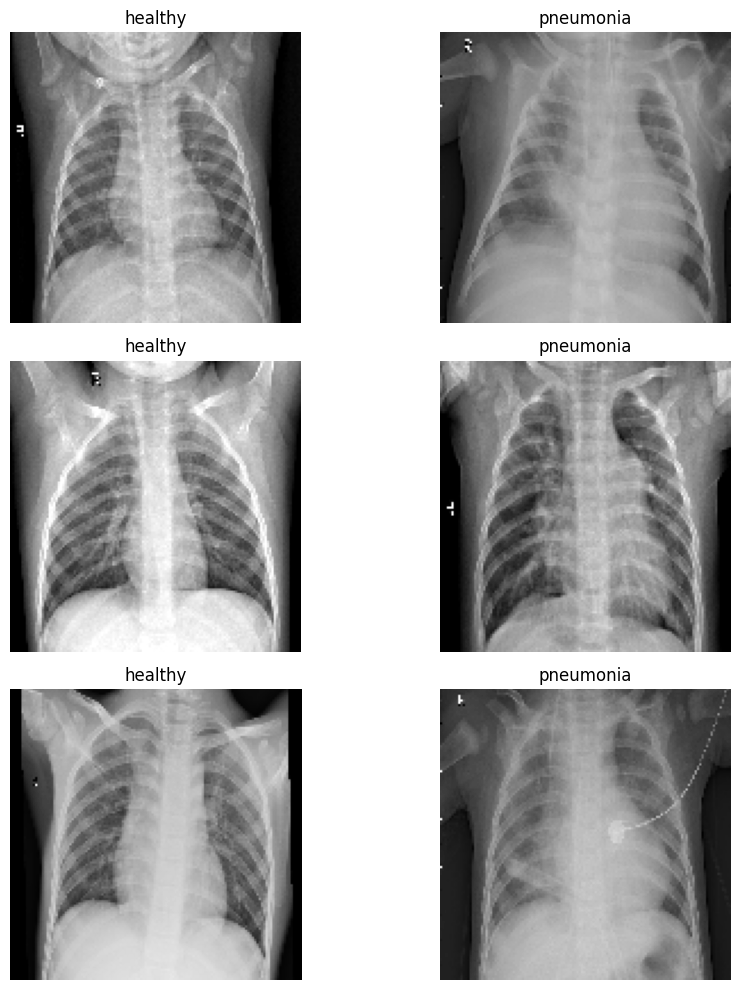

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
ds = PneumoniaXRayDataset('train')

for i, ax in enumerate(axs):
    ax[0].imshow(ds.img[ds.lbl == 0][i].squeeze(), cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('healthy')

    ax[1].imshow(ds.img[ds.lbl == 1][i].squeeze(), cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('pneumonia')

plt.tight_layout()

# **Task 1: Build an encoder-decoder architecture and train with KLD loss**

Create an encoder that takes $B\times1\times128\times128$ input images and produces two 512 dim. latent vectors ($\mu$ and $\log(\sigma^2)$). Therefore implement the `CBR` function that returns two Conv2d → BNorm → LeakyReLU groups wrapped in a `nn.Sequential`. Both Convs have `kernel_size=3` and `padding=1`. The second one also reduces the spatial resolution by factor 2 via `stride=2`.

In [11]:
def CBR(in_channel, out_channel):
    mu = nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channel),
      nn.LeakyReLU()
    )

    logvar = nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=2),
      nn.BatchNorm2d(out_channel),
      nn.LeakyReLU()
    )
    return mu, logvar


The decoder takes a $B\times512\times1\times1$ $z$-vector and generates a fully-sized ($B\times1\times128\times128$) output image. So its convolutional building blocks returned by `upCBR` have to reconstruct the spatial dimension. This is done via `nn.Upsample` with `mode=bilinear` and `align_corners=False` followed by a Conv2d → BNorm → LeakyReLU group with `kernel_size=3` and `padding=1`.

In [10]:
def upCBR(in_channel, out_channel):
  decoder = nn.Sequential(
    nn.Upsample(mode='bilinear', align_corners=False),
    nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_channel),
    nn.LeakyReLU()
  )


Now, let's build the VAE. The encoder takes $B\times1\times128\times128$ input images and produces a 128 dim. latent vector, that are used to generate the 512 dim $\mu$ and $\log(\sigma^2)$ vectors via two fully connected $1\times1$ convolutions `fc_mu`and `fc_log_var`.

The encoder consists of four `CBR` blocks:
+ `CBR(1, 16)`
+ `CBR(16, 32)`
+ `CBR(32, 64)`
+ `CBR(64, 64)`

followed by a last Conv2d → BNorm → LeakyReLU group, that project the $B\times64\times8\times8$ to a $B\times128\times1\times1$ vector. Choose its kernel size appropriate.

Next, implement the decoder, which takes a $B\times512\times1\times1$ $z$-vector and generates a fully-sized ($B\times1\times128\times128$) output image. Start with a `ConvTranspose2d`  with kernel=8, channel-out=64 and no padding, followed by four `upCBR`:

+ `upCBR(64, 32)`
+ `upCBR(32, 16)`
+ `upCBR(16, 8)`
+ `upCBR(8, 8)`

Close the VAE with a $1\times1$ convolution to project the channel to one single output channel, followed by a `nn.Tanh`.

Build a VAE with your encoder-decoder architecture, you can follow [this example](https://github.com/pytorch/examples/blob/master/vae/main.py).
**Note**: that `mu` and `log_var` have to be returned after the forward path for loss calculations.

In [13]:
# Skeleton for task 1
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc_mu = nn.Linear()
        self.fc_log_var = nn.Linear()

        self.encoder = nn.Sequential(
        CBR(1, 16),
        CBR(16, 32),
        CBR(32, 64),
        CBR(64, 64),

        nn.Conv2d(64,128, kernel_size=8),
        nn.BatchNorm2d(128),
        nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(512, 64, kernel_size=8),
        upCBR(64, 32),
        upCBR(32, 16),
        upCBR(16, 8),
        upCBR(8, 8),


        nn.Conv2d(8,1),
        nn.Tanh(),
        )


    def reparameterize(self, mu, logvar):
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      return mu + eps*std

    def encode(self, x):
        # get encoding

        # predict distribution parameters
        mu, log_var = self.encoder(1, 128)

        # reparameterize
        z = self.reparameterize(mu, log_var)

        return z, mu, log_var

    def forward(self, x):
        mu, log_var = self.encode(1, 128)
        x_hat = self.decoder(z)

        return x_hat, mu, log_var

Check your VAE's architecture using the `summary` function from `torchinfo` with a batch size of 1. You should obtain about $2\,925\,433$ parameters.

In [14]:
!pip install torchinfo
from torchinfo import summary

summary(VAE(), batch_size=1)

TypeError: ignored

## L1 and KLD Loss

Implement the loss function, consisting of the L1 distance between the image and the reconstructed one (use `F.F.l1_loss`) and the kullback leibler divergence following this formula:
$$\text{KLD}= -0.5\cdot\frac{1}{N}\cdot\sum_n^N\left(1+\log(\sigma_n^2)-\mu^2_n-\sigma_n^2\right)$$
Add both loss, but divide KLD by the number of pixels to make the reconstruction loss more important and return the result.

In [ ]:
def loss_function(x_hat, x, mu, logvar):
    """
    loss for unsupervised training of a VAE with L1-norm and KLD
    :param x_hat: reconstructed image
    :param x: original image
    :param mu: mean of the predicted latent space distribution
    :param logvar: logarithmic variation of the predicted latent space distribution
    :return:
    """
    # todo

## Training
Train this network for 300 epochs with `batch_size=32` and `shuffle=True` using a `DataLoader` and a `Adam` optimizer with its default settings. Use the L1loss for the reconstruction of images and the Kullback-Leibler divergence (KLD) as loss function. Use the learning rate scheduler `MultiStepLR` to reduce the learning rate by a factor of 10 after 200 and 280 epochs (do not forget to call `step()` on the scheduler after each epoch). You should obtain a loss of about $0.018$ after 300 epochs.

In [ ]:
from tqdm import trange, tqdm
from torch.utils.data import DataLoader
from torchmetrics import MeanMetric

data_laoder = DataLoader(dataset=PneumoniaXRayDataset(mode='train'),
                         batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)

model = # todo

optimizer = # todo
scheduler = # todo

loss_history = []
collector = MeanMetric(nan_strategy='error').cuda()
for epoch in trange(300, unit='epoch'):
    # train the VAE
    model.train()

    # for each mini-batch
    for x, _ in data_laoder:
        # forward
        loss = # todo

        # backward and optimize
        # todo

        # calculate mean loss
        collector(loss)

    # update learning rate
    # todo

    # track loss
    loss_history.append(collector.compute().item())

    # visualize some reconstructions
    if epoch % 10 == 0:
        tqdm.write(f'{epoch}: {collector.compute().item()} L1 + KDE loss')
        model.eval()
        with torch.no_grad():
            x_hat, _, _ = model(x)
            fig, ax = plt.subplots(2, 2, figsize=(10, 10))

            ax[0, 0].imshow(x[0].squeeze().cpu(), cmap='gray')
            ax[0, 1].imshow(x_hat[0].squeeze().cpu(), cmap='gray')

            ax[1, 0].imshow(x[1].squeeze().cpu(), cmap='gray')
            ax[1, 1].imshow(x_hat[1].squeeze().cpu(), cmap='gray')

            plt.show()

    collector.reset()

torch.save(model, 'vae_task1.pt')
del model

# plot loss history
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('overview')

plt.figure()
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('zoomed in')
plt.ylim(min(loss_history) * 0.9, 0.03)

# Task 2: Smooth interpolation between samples
One big advantage of a VAE is its continuous and so interpretable latent space. We can demonstrate this by creating two $z$ vectors of two image and interpolating them in the $z$-space obtaining smooth transition images.

First we encode the two given images `img1` and `img2` to their $z$ vectors `z_1` and `z_2` using the encoder of our trained VAE. Next, we create the `z` tensor, that holds $n\times512\times1\times1$ interpolated $z$ vectors. To obtain the weight for the interpolation use `torch.linspace(0, 1, n)`. Reconstruct the images with the decoder of the VAE. Use the provided function `plot_transition_img` to plot the results.

In [ ]:
# provided function for plotting the transition using a tensor of shape [nx1x128x128]
def plot_transition_img(imgs: torch.Tensor, n: int):
    fig, ax = plt.subplots(1, n, figsize=(20,3))
    fig.suptitle('Reconstructions')
    for i in range(n):
        ax[i].imshow(reconstructed_imgs[i].squeeze(), cmap='gray')

In [ ]:
model = torch.load('vae_task1.pt').cpu().eval()
ds = PneumoniaXRayDataset('train')

n = 8

img1 = ds.img[1]
img2 = ds.img[5]

fig, ax = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Original images')
ax[0].imshow(img1.squeeze(), cmap='gray')
ax[1].imshow(img2.squeeze(), cmap='gray')

with torch.no_grad():
    z_1 = # todo
    z_2 = # todo

z = # todo

with torch.no_grad():
    reconstructed_imgs = # todo

plot_transition_img(reconstructed_imgs, n)
del model

# **Bonus task: Implement a perceptual loss and add this to your VAE training  (5 points)**

 A pre-trained fully-convolutional network which encoder is adapted to the VAE's one has been trained for the pneumonia classification and is provided for this task.

In [ ]:
!wget -nc https://drive.google.com/file/d/1BairhYZs3uGvjbcgHC_IUD5NCsAdefT4/view?usp=sharing -O pneumonina_cnn.py
!wget -nc https://drive.google.com/file/d/1W_9kfN_Vi7DdkDBDs5sIwCHW8arzRyeK/view?usp=sharing -O pneumonia_model.pt

In [ ]:
from pneumonia_cnn import *

pretrainend_classification_model = torch.load('pneumonia_model.pt').eval().cuda()

## Perceptual Loss function
Complete the `perceptual_loss` function. Index the encoder of the pretrained model and of the VAE and calculate the difference between their feature using the `F.l1_loss`. Feature should be extracted after the last activation function of the spatial resolution $64^2, 32^2, 16^2$. Sum up the losses and return the result.

In [ ]:
def perceptual_loss(pretrainend_model, model, x):
    # feature pretrainend model
    # todo

    # feature model
    # todo

    # calculate loss
    loss = # todo

    return loss

Retrain the VAE with the same training routine like task 1, but with the additional perceptual loss. The visual results will get a little more blurry, but the training converge faster and is able to already produce some meaningfully results in the very first epochs.

In [ ]:
#implement the perceptual loss and retrain your VAE

# todo

torch.save(model, 'vae_perceptual_loss.pt')